In [1]:
# NetWatch_GeneratedData_Models.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib

# === 1. LOAD & CLEAN GENERATED DATA ===

print("\n📥 Loading simulated NetWatch data...")
df = pd.read_csv("Generated_data/netwatch_wifi_data_dirty.csv")

df = df.sort_values(['home_id', 'device_id', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Visual inspection
print(df.info())
print(df.describe())
print(df.head())


📥 Loading simulated NetWatch data...
<class 'pandas.core.frame.DataFrame'>
Index: 50145 entries, 0 to 49648
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   home_id           50145 non-null  int64         
 1   device_id         50145 non-null  object        
 2   timestamp         50145 non-null  datetime64[ns]
 3   rssi              48145 non-null  float64       
 4   latency_ms        48145 non-null  float64       
 5   jitter_ms         48155 non-null  float64       
 6   packet_loss       49644 non-null  float64       
 7   is_connected      50145 non-null  int64         
 8   experience_score  50145 non-null  float64       
 9   predicted_outage  50145 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 4.2+ MB
None
            home_id                      timestamp          rssi  \
count  50145.000000                          50145  4814

## Visualize Nulls, Outliers, Weird Disconnects 


🧼 Visualizing missing/nulls...


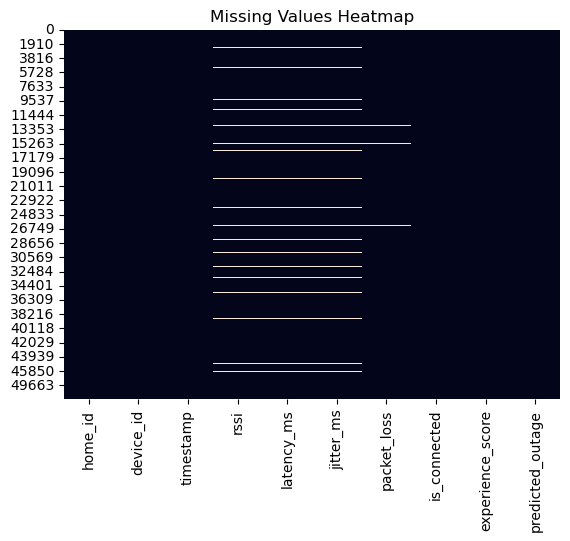

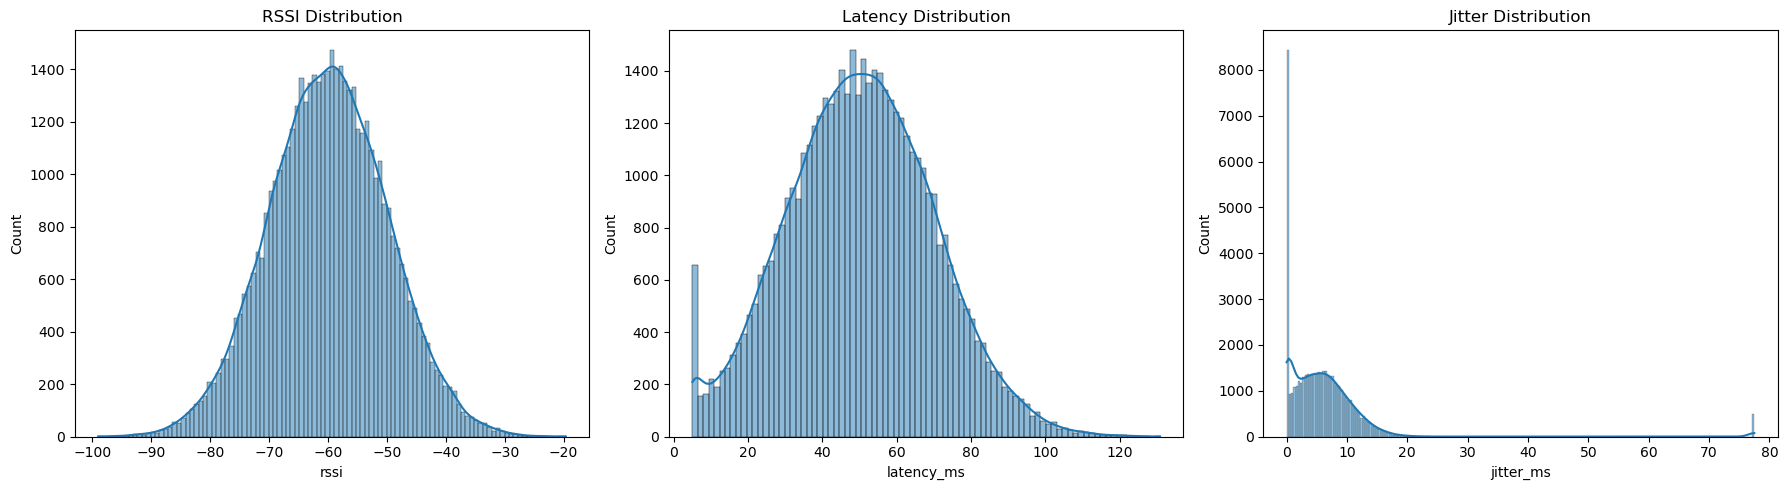

⚠️ Weird Disconnects: 968


In [2]:
# === 2. EXPLORATION ===

print("\n🧼 Visualizing missing/nulls...")
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['rssi'], kde=True, ax=ax[0])
sns.histplot(df['latency_ms'], kde=True, ax=ax[1])
sns.histplot(df['jitter_ms'], kde=True, ax=ax[2])
ax[0].set_title("RSSI Distribution")
ax[1].set_title("Latency Distribution")
ax[2].set_title("Jitter Distribution")
plt.tight_layout()
plt.show()

# Weird disconnects
weird = df[(df['is_connected'] == 0) & (df['rssi'] > -65) & (df['latency_ms'] < 80)]
print("⚠️ Weird Disconnects:", weird.shape[0])

In [3]:
# === 3. CLEANING ===

print("\n🧹 Cleaning simulated dataset...")
df.drop_duplicates(inplace=True)
df['rssi'].fillna(df['rssi'].median(), inplace=True)
df['latency_ms'].fillna(df['latency_ms'].median(), inplace=True)
df['jitter_ms'].fillna(df['jitter_ms'].median(), inplace=True)
df['jitter_ms'] = df['jitter_ms'].clip(upper=300)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['home_id', 'device_id', 'timestamp'], inplace=True)
df.to_csv("Generated_data/netwatch_wifi_cleaned.csv", index=False)


🧹 Cleaning simulated dataset...


In [4]:
# === 4. MODEL TRAINING ===

print("\n📊 ML Training for Regression + Classification")
df = pd.read_csv("Generated_data/netwatch_wifi_cleaned.csv")
df_model = df.dropna(subset=['rssi', 'latency_ms', 'jitter_ms', 'packet_loss', 'experience_score', 'predicted_outage'])
features = ['rssi', 'latency_ms', 'jitter_ms', 'packet_loss']

# Regression
X = df_model[features]
y_reg = df_model['experience_score']
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("\n📈 RMSE (experience_score):", rmse)
joblib.dump(regressor, "models/experience_score_model.pkl")

# Classification
y_clf = df_model['predicted_outage']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_c, y_train_c)
y_pred_c = classifier.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_c)
print("\n🚨 Accuracy (outage prediction):", acc)
print(classification_report(y_test_c, y_pred_c))
joblib.dump(classifier, "models/outage_detector_model.pkl")





📊 ML Training for Regression + Classification

📈 RMSE (experience_score): 0.008161759444365025

🚨 Accuracy (outage prediction): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9835

    accuracy                           1.00      9835
   macro avg       1.00      1.00      1.00      9835
weighted avg       1.00      1.00      1.00      9835



['models/outage_detector_model.pkl']


📈 Plotting experience score trend...


/var/folders/fq/g897wng54x73hj9ss__c8p7c0000gn/T/ipykernel_75483/3363437633.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/keerthichowdarygogineni/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


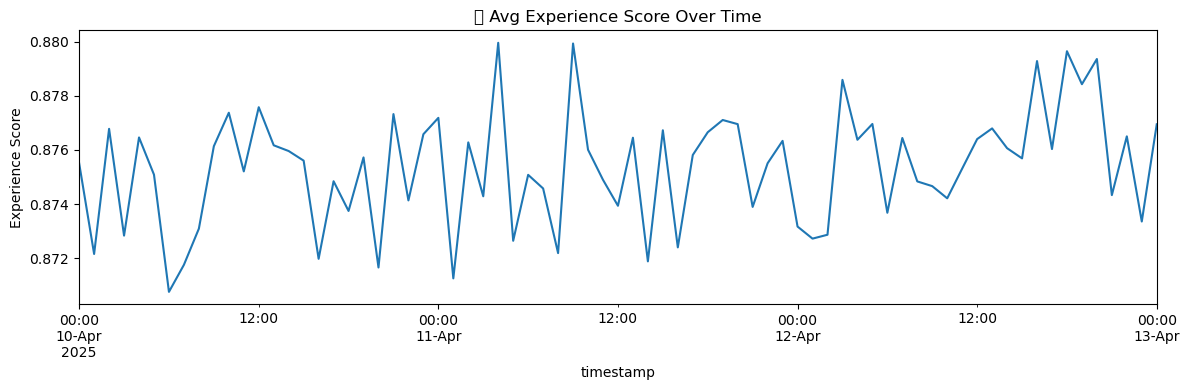

In [5]:
# === 5. EXPERIENCE SCORE TREND ===

print("\n📈 Plotting experience score trend...")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df['experience_score'].resample('1H').mean().plot(figsize=(12,4), title="📊 Avg Experience Score Over Time")
plt.ylabel("Experience Score")
plt.tight_layout()
plt.show()

In [6]:
# === 6. OUTAGE DETECTION LOGIC ===
print("\n⚠️ Running outage detection logic...")

# Ensure timestamp exists
if 'timestamp' not in df.columns:
    df = df.reset_index()

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['home_id', 'timestamp'])

# Set datetime index
df = df.set_index('timestamp')

# Filter disconnected events only
disconnect_df = df[df['is_connected'] == 0].copy()

# We need a numeric column for rolling, so let's use 'is_connected'
disconnect_df['dummy'] = 1  # just a placeholder

# Store alerts here
alerts_list = []

# Group by home_id
for home_id, group in disconnect_df.groupby("home_id"):
    rolled = group.rolling('15min')

    # Create rolling window list of device_ids
    for window_end in group.index:
        window_start = window_end - pd.Timedelta(minutes=15)
        window = group.loc[window_start:window_end]
        unique_devices = window['device_id'].nunique()

        if unique_devices >= 3:
            alerts_list.append({
                "home_id": home_id,
                "timestamp": window_end,
                "affected_devices": unique_devices,
                "alert_type": "Multi-device dropout",
                "severity": "High"
            })

# Convert to DataFrame
alerts_df = pd.DataFrame(alerts_list)
print(alerts_df.head())
alerts_df.to_csv("logs/incident_log.csv", index=False)


⚠️ Running outage detection logic...
   home_id           timestamp  affected_devices            alert_type  \
0        2 2025-04-11 06:30:00                 3  Multi-device dropout   
1        2 2025-04-11 06:30:00                 3  Multi-device dropout   
2        2 2025-04-11 06:30:00                 3  Multi-device dropout   
3        3 2025-04-11 19:20:00                 3  Multi-device dropout   
4        3 2025-04-11 19:20:00                 3  Multi-device dropout   

  severity  
0     High  
1     High  
2     High  
3     High  
4     High  



📈 Sample time series per home


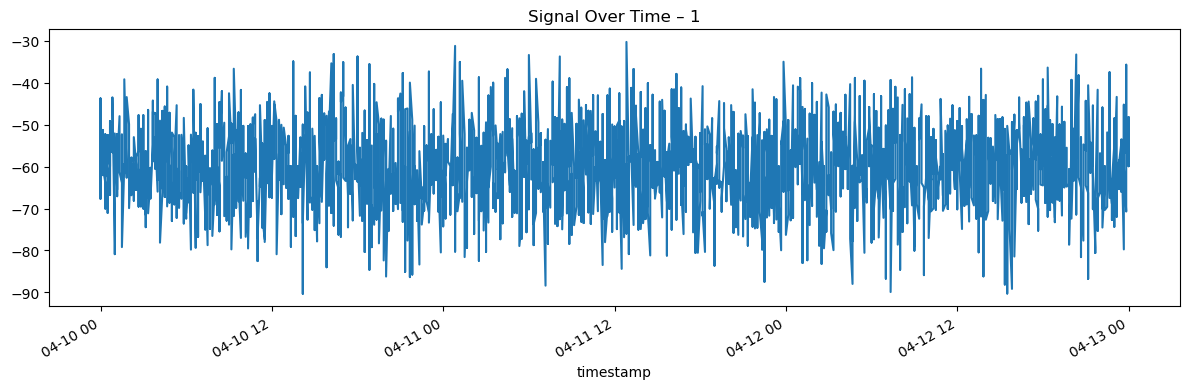

In [7]:
# === 7. TIME SERIES EXPLORER EXAMPLE ===

print("\n📈 Sample time series per home")
df.reset_index(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
home_sample = df[df['home_id'] == df['home_id'].iloc[0]]
home_sample.set_index('timestamp')['rssi'].plot(figsize=(12,4), title=f"Signal Over Time – {home_sample['home_id'].iloc[0]}")
plt.tight_layout()
plt.show()


🧠 Clustering device behavior...


/Users/keerthichowdarygogineni/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/fq/g897wng54x73hj9ss__c8p7c0000gn/T/ipykernel_75483/1928944266.py:18: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/Users/keerthichowdarygogineni/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


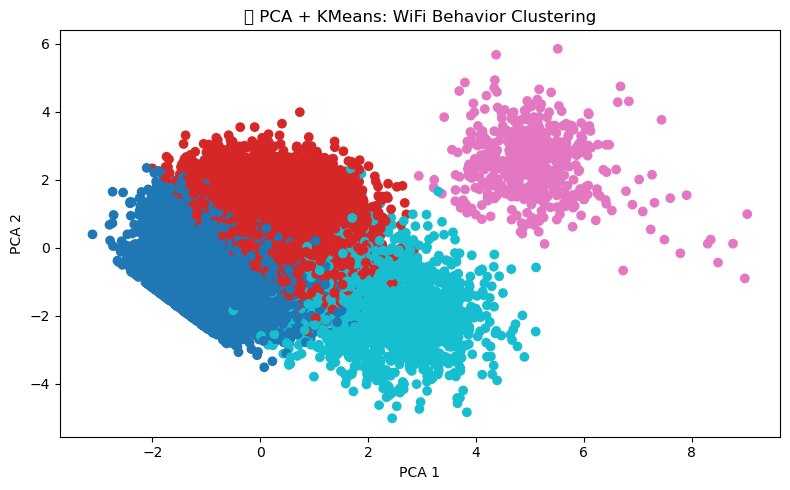

In [8]:
# === 8. CLUSTERING BEHAVIOR PROFILES ===

print("\n🧠 Clustering device behavior...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
df_model['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,5))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df_model['cluster'], cmap='tab10')
plt.title("🧠 PCA + KMeans: WiFi Behavior Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()